In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
'Colab Notebooks'	  flower	 generator_plot.png  'NN Structure'
 discriminator_plot.png   gan_plot.png	 landscape	      Portrait


In [ ]:
# load the prepared dataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

In [ ]:
# example of a gan for generating faces

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample to 40x40
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample to 20x20
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample to 10x10
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample to 5x5
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

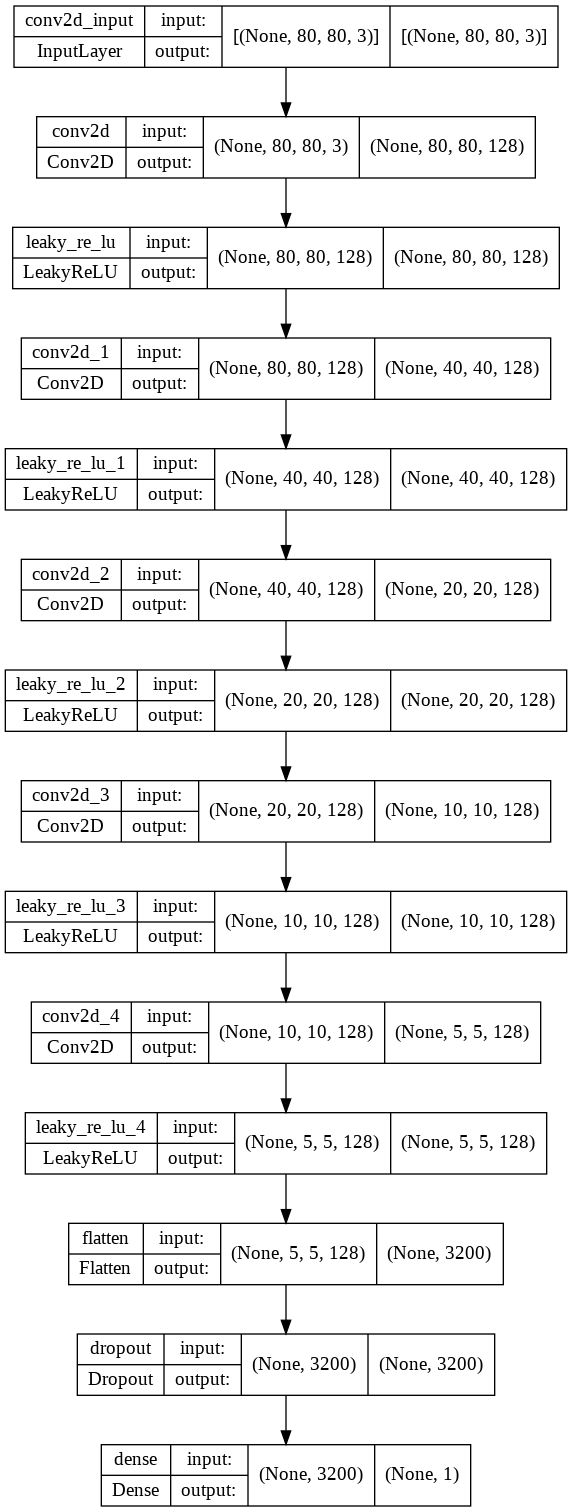

In [ ]:
discriminator = define_discriminator()
plot_model(discriminator, to_file='NN Structure/discriminator_plot_Portrait80.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 5x5 feature maps
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5, 5, 128)))
  # upsample to 10x10
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 20x20
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 40x40
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 80x80
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer 80x80x3
  model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model

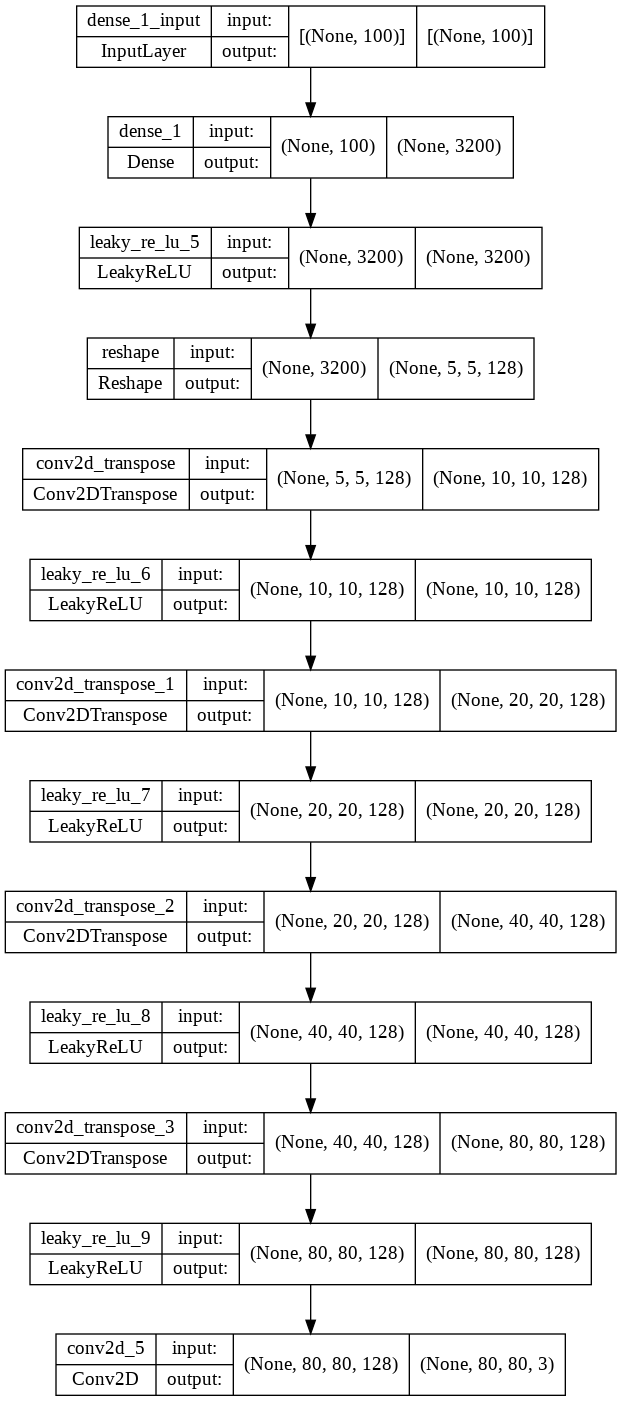

In [ ]:
generator = define_generator(100)
plot_model(generator, to_file='NN Structure/generator_plot_portrait80.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

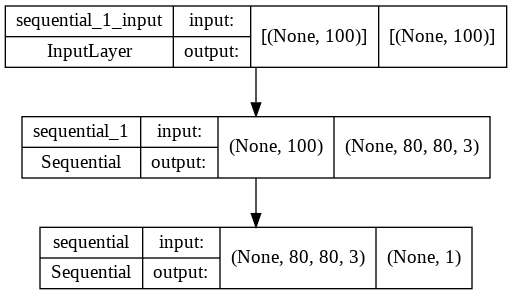

In [ ]:
gan = define_gan(generator,discriminator)
plot_model(gan, to_file='NN Structure/gan_plot_portrait80.png', show_shapes=True, show_layer_names=True)

In [ ]:
# load and prepare training images
def load_real_samples():
  # load the face dataset
  data = np.load("Portrait/portrait.npz")
  X = data['arr_0']
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=2):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i])
  # save plot to file
  filename = 'Face_2by2%03d.png' % (epoch+1)
  plt.savefig("Colab Notebooks/MyColab/"+filename)
  plt.close()


In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=4):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'Face_2by2%03d.h5' % (epoch+1)
  g_model.save("Colab Notebooks/MyColab/"+filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=400):
  # n_epochs = 2, to try, original is 100
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    # if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model,d_model,gan_model,dataset,latent_dim)

In [ ]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

In [ ]:
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
  fig = plt.figure(figsize = (20,16))
  for i in range(n * n):
		# define subplot
	  pyplot.subplot(n, n, 1 + i)
		# turn off axis
	  pyplot.axis('off')
		# plot raw pixel data
	  pyplot.imshow(examples[i, :, :])
  pyplot.show()

IndexError: ignored

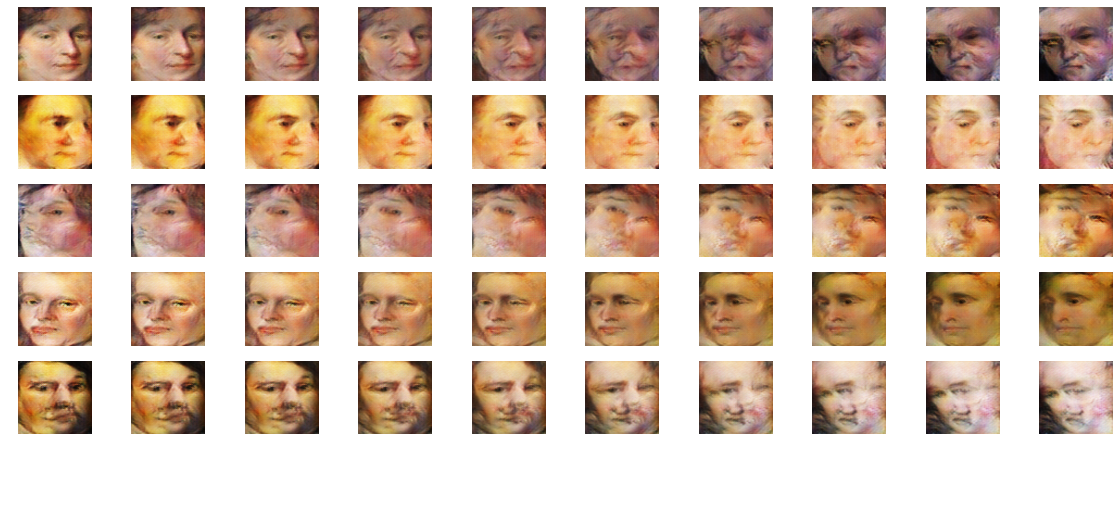

In [ ]:
# load model
model = load_model('Colab Notebooks/MyColab/Face_500.h5')
# generate points in latent space
n = 10
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results,10)